## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [106]:
from types import SimpleNamespace
config = {
    'lower_yellow': np.uint8([ 10,   0, 100]), # lower threshold for yellow color in HSL
    'upper_yellow': np.uint8([ 40, 255, 255]), # upper threshold for yellow color in HSL
    'yuv_u_threshold': 105,
    'gray_threshold': 215,
    'xm_per_pix': 3.7/(1065-250), # meters per pixel in x dimension
    'ym_per_pix': 30/720 # meters per pixel in y dimension
}
config = SimpleNamespace(**config)

## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calibration_images = glob.glob('../camera_cal/calibration*.jpg')

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners_sub = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners_sub)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners_sub, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
temp = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
mtx = temp[1] # camera matrix
dist = temp[2] # distortion coefficients
rvecs = temp[3] # rotation vector 
tvecs = temp[4] # translation vector

## Calculate Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. 

In [2]:
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error

print("Total error: ", tot_error/len(objpoints))

Total error:  0.10841442348876729


## Image Undistortion

In [3]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

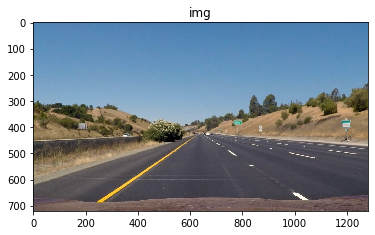

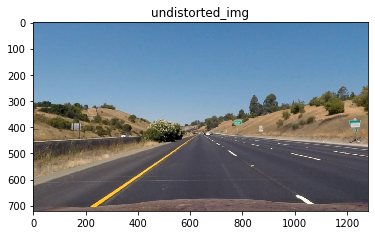

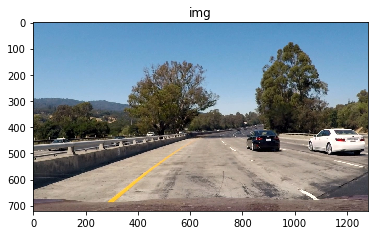

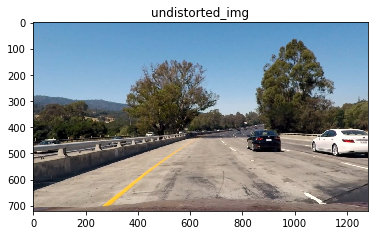

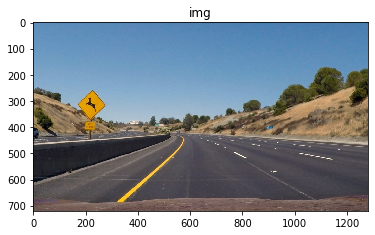

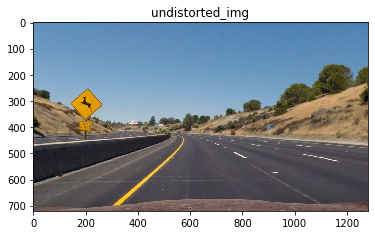

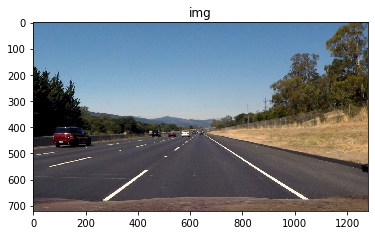

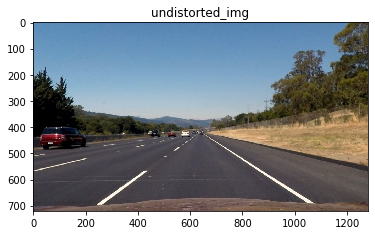

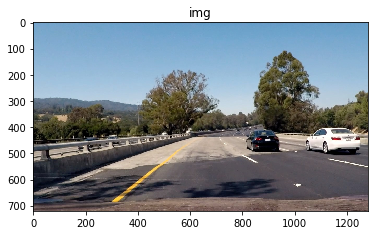

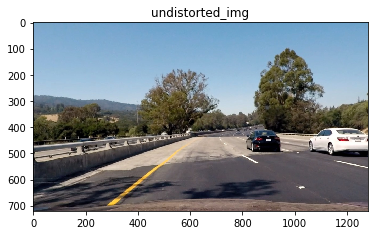

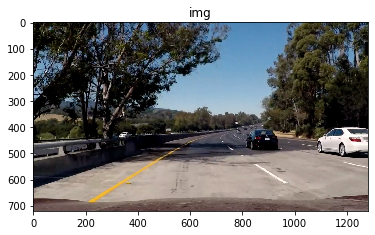

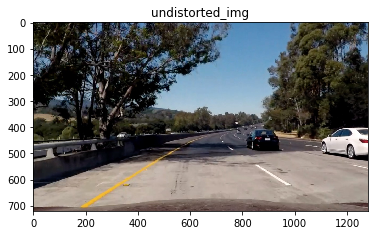

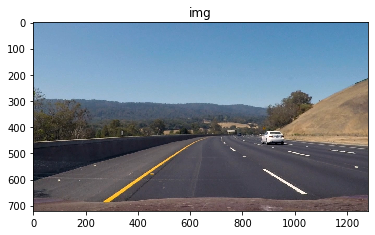

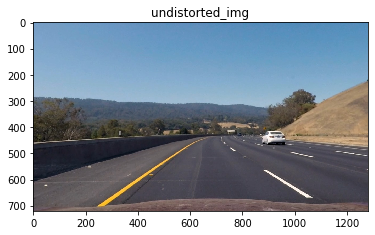

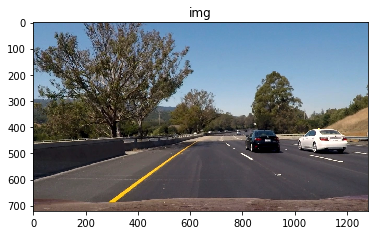

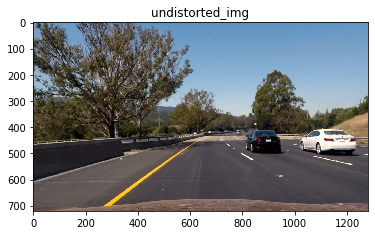

In [4]:
test_images = glob.glob('../test_images/*.jpg')
    
for fname in test_images:
    img = mpimg.imread(fname)
    undistorted_img = undistort_image(img, mtx, dist)
    plt.imshow(img)
    plt.title('img')
    plt.show()
    plt.title('undistorted_img')
    plt.imshow(undistorted_img)
    plt.show()


# Find lane points

## Helper functions

In [112]:
def convert_rgb_to_hsl(img):
    """Converts RGB iamge to HSL colorspace"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def extract_yellow_hls(img):
    """
    Extracts all white and yellow pixels in HSL colorspace
    
    This function expects an image in the HSL format. Make sure
    you have converted your image to this colorspace. Yellow and white pixels
    are extracted based on an upper and lower threshold. 
    """
    yellow_mask = cv2.inRange(img, config.lower_yellow, config.upper_yellow)
    return cv2.bitwise_and(img, img, mask = yellow_mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    rgb_image = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def region_of_interest_mask(img):
    """
    Constructs an image mask
    
    The region of interest has 4 vertices, which are 
    calculated based on the image dimension.
    """
    shape_img = img.shape
    vertices = np.array([[
        (0,shape_img[0]),
        ((9*shape_img[1])/20, (3*shape_img[0])/5),
        ((11*shape_img[1])/20, (3*shape_img[0])/5),
        (shape_img[1],shape_img[0])
    ]], dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def color_selection(img):
    yellow_img = extract_yellow_hls(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
    temp = cv2.cvtColor(yellow_img, cv2.COLOR_HLS2RGB)
    gray_yellow=cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_planes = cv2.split(yuv_img)
    
    binary = np.zeros_like(yuv_planes[0])
    binary[(yuv_planes[1] < config.yuv_u_threshold) | (gray > config.gray_threshold) | (gray_yellow > 0)] = 1
    
    return binary

def measure_radius_of_curvature(fit_cr, img):
    y_eval = img.shape[1] * config.ym_per_pix
    curverad = ((1 + (2*fit_cr[0]*y_eval*config.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad


def add_metrics(img, left_fit, right_fit):
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_fit, img)
    right_curve_rad = measure_radius_of_curvature(right_fit, img)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    cv2.putText(img,"Radius of Curvature: %.2f m" % average_curve_rad ,\
                       (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    print(left_fit)
    
    x_max_real = img.shape[1]*config.xm_per_pix
    y_max_real = img.shape[0]*config.ym_per_pix
    
    vehicle_center = x_max_real / 2
    line_left = left_fit[0]*y_max_real**2 + left_fit[1]*y_max_real + left_fit[2]
    line_right = right_fit[0]*y_max_real**2 + right_fit[1]*y_max_real + right_fit[2]
    line_center = line_left + (line_right - line_left)/2
    offset = line_center - vehicle_center
    
    cv2.putText(img, "Center Offset: %.2f m" % offset,\
                (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_real = np.polyfit(lefty*config.ym_per_pix, leftx*config.xm_per_pix, 2)
    right_fit_real = np.polyfit(righty*config.ym_per_pix, rightx*config.xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    return color_warp, left_fit_real, right_fit_real


def plt_images(img_1, title_1, img_2, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2)
    

In [113]:
def get_warp_coordinates(img):
    
    src_coordinates = np.float32(
            [[280,  img.shape[0]-20],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, img.shape[0]-20]]) # Bottom right
        
    dst_coordinates = np.float32(
            [[250,  img.shape[0]],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, img.shape[0]]]) # Bottom right 
    return src_coordinates, dst_coordinates

def warp_image(img, src_coordinates, dst_coordinates):
    
    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    warp = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
    return warp

[-7.94166899e-05  9.01286310e-03  7.47233767e-01]


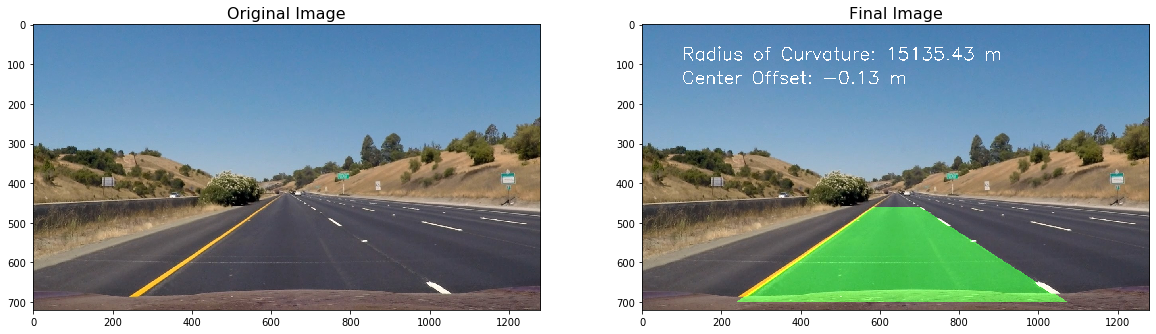

[ 4.02914801e-04 -1.65394644e-02  1.20854153e+00]


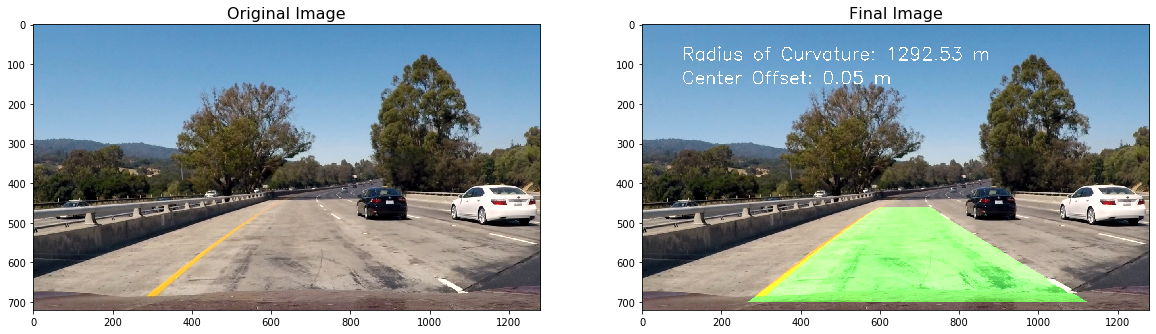

[-0.00075874  0.05001104  0.45192433]


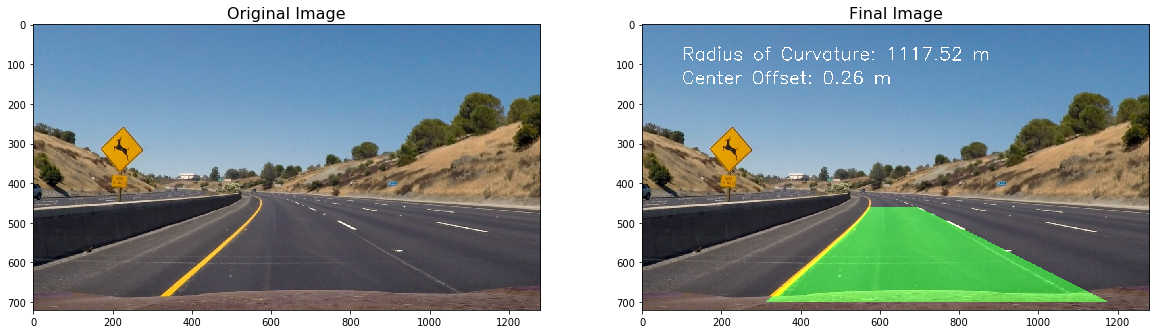

[1.17359113e-04 4.43860484e-03 7.48770480e-01]


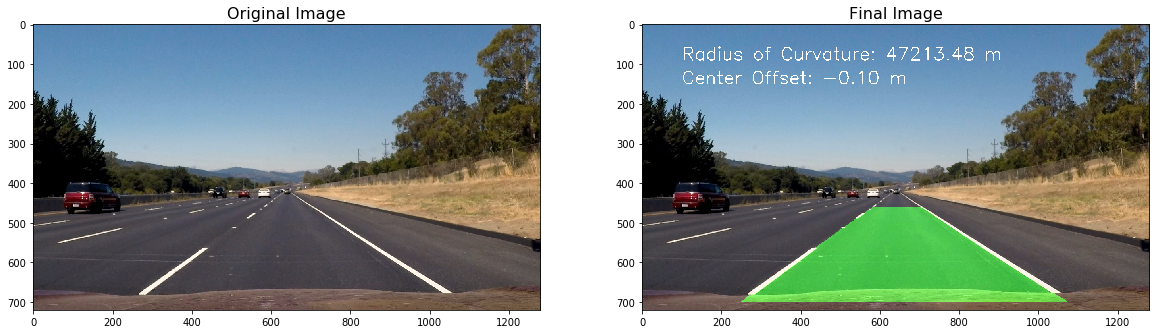

[ 3.28447857e-04 -1.05259126e-02  1.21237289e+00]


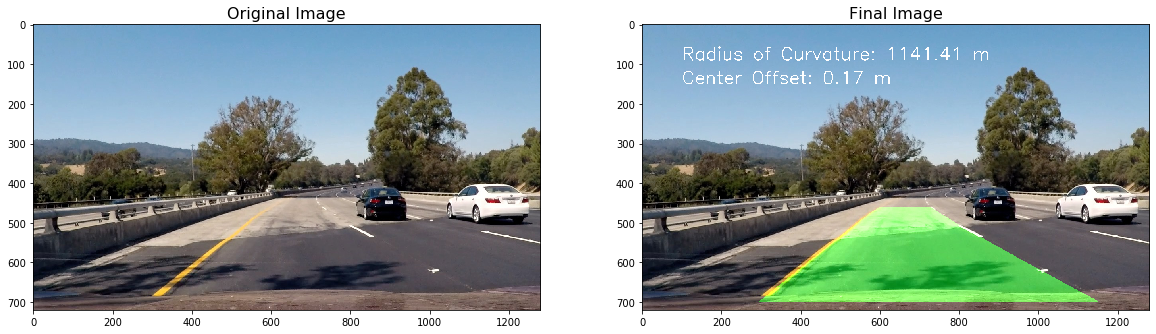

[ 1.04748475e-03 -4.72953771e-02  1.29415242e+00]


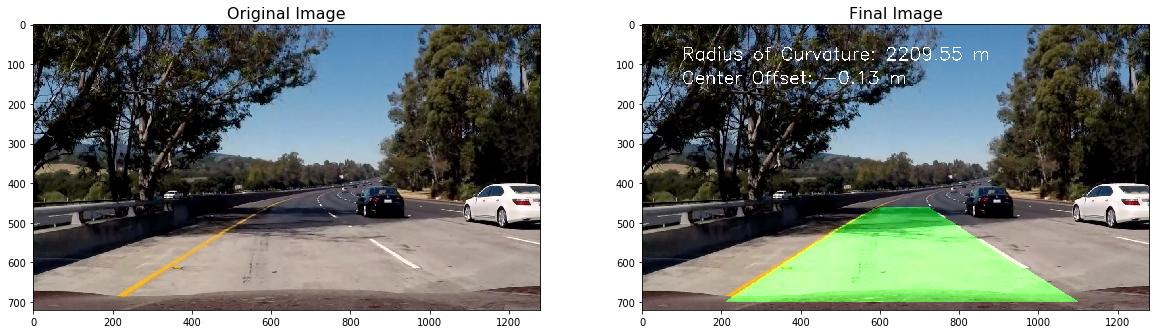

[ 3.46167639e-04 -2.92797738e-02  1.61599787e+00]


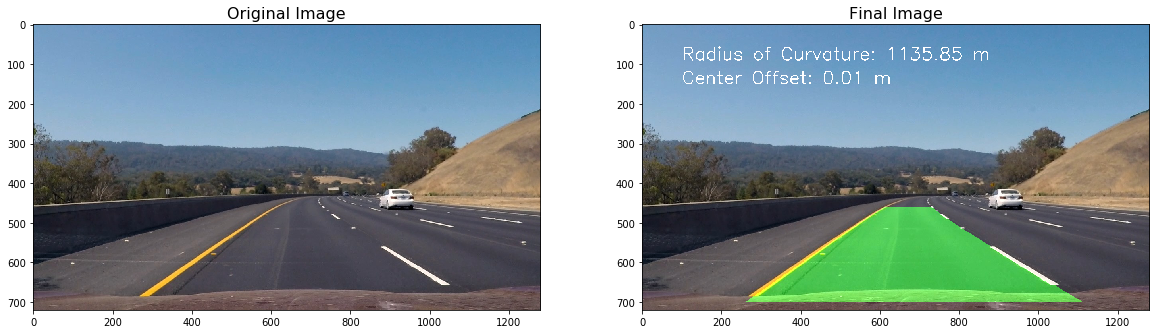

[ 4.83671636e-04 -3.55543711e-02  1.77388027e+00]


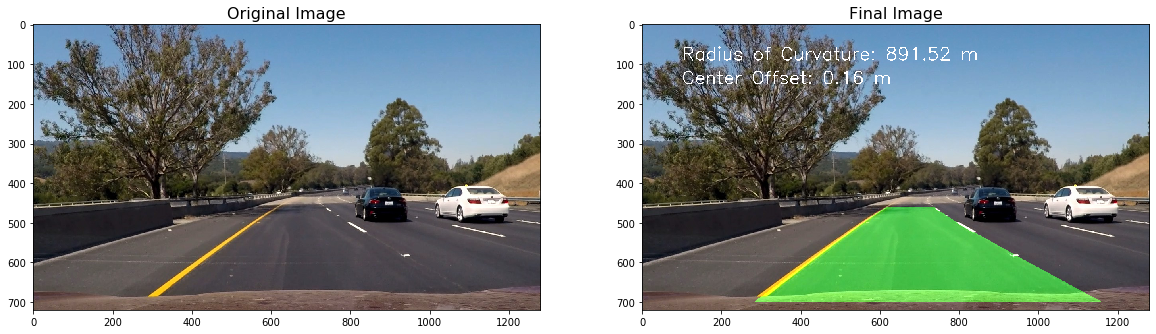

In [114]:
for fname in test_images:
    img = mpimg.imread(fname)

    undistorted_img = undistort_image(img, mtx, dist)
    
    src_coordinates, dst_coordinates = get_warp_coordinates(undistorted_img)
    
    roi_mask = region_of_interest_mask(undistorted_img)
    roi_img = region_of_interest(undistorted_img, roi_mask)   
    
    binary = color_selection(roi_img)

    warped_img = warp_image(binary, src_coordinates, dst_coordinates)
    
    warped_lanes_img, left_fit_real, right_fit_real = fit_polynomial(warped_img)
    unwarped_lanes_img = warp_image(warped_lanes_img, dst_coordinates, src_coordinates)
    annotated_img = cv2.addWeighted(img, 1, unwarped_lanes_img, 0.5, 0)
    
    add_metrics(annotated_img, left_fit_real, right_fit_real)
    
    plt_images(img, 'Original Image', annotated_img, 'Final Image')
    plt.show()
    

In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [116]:
def process_image(img):
    annotated_img = None
    try:
        undistorted_img = undistort_image(img, mtx, dist)
    
        src_coordinates, dst_coordinates = get_warp_coordinates(undistorted_img)
    
        roi_mask = region_of_interest_mask(undistorted_img)
        roi_img = region_of_interest(undistorted_img, roi_mask)   
    
        binary = color_selection(roi_img)

        warped_img = warp_image(binary, src_coordinates, dst_coordinates)
    
        warped_lanes_img, left_fit_real, right_fit_real = fit_polynomial(warped_img)
        unwarped_lanes_img = warp_image(warped_lanes_img, dst_coordinates, src_coordinates)
        annotated_img = cv2.addWeighted(img, 1, unwarped_lanes_img, 0.5, 0)
    
        add_metrics(annotated_img, left_fit_real, right_fit_real)
    except:
        print("something went wrong")
        return img
    
    return annotated_img

In [104]:
project_video_output = '../project_video_output.mp4'
clip1 = VideoFileClip('../project_video.mp4')
project_video_clip = clip1.fl_image(process_image)
%time project_video_clip.write_videofile(project_video_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:24, 14.94it/s, now=None]

Moviepy - Building video ../project_video_output.mp4.
Moviepy - Writing video ../project_video_output.mp4




t:  12%|█▏        | 153/1260 [00:17<02:12,  8.35it/s, now=None]


t:  24%|██▍       | 305/1260 [00:35<01:44,  9.15it/s, now=None]


t:  37%|███▋      | 464/1260 [00:52<01:29,  8.92it/s, now=None]


t:  49%|████▊     | 614/1260 [01:10<01:16,  8.46it/s, now=None]


t:  61%|██████    | 767/1260 [01:28<01:04,  7.60it/s, now=None]


t:  73%|███████▎  | 918/1260 [01:45<00:43,  7.88it/s, now=None]


t:  83%|████████▎ | 1046/1260 [02:02<00:36,  5.94it/s, now=None]


t:  93%|█████████▎| 1175/1260 [02:19<00:10,  8.06it/s, now=None]


t:   1%|▏         | 7/485 [5:31:58<00:40, 11.85it/s, now=None]  

Moviepy - Done !
Moviepy - video ready ../project_video_output.mp4
CPU times: user 5min 30s, sys: 6.59 s, total: 5min 37s
Wall time: 2min 33s


In [105]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [24]:
video_challenge_output = '../challenge_video_output.mp4'
clip2 = VideoFileClip('../challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(video_challenge_output, audio=False)

t:   0%|          | 2/485 [00:00<00:25, 19.01it/s, now=None]

Moviepy - Building video ../challenge_video_output.mp4.
Moviepy - Writing video ../challenge_video_output.mp4




t:  28%|██▊       | 138/485 [00:18<00:44,  7.72it/s, now=None]


t:  54%|█████▍    | 263/485 [00:38<00:34,  6.45it/s, now=None]


t:  81%|████████  | 393/485 [00:57<00:13,  6.80it/s, now=None]


t:   1%|▏         | 7/485 [02:46<00:40, 11.85it/s, now=None]  

Moviepy - Done !
Moviepy - video ready ../challenge_video_output.mp4
CPU times: user 2min 7s, sys: 4.86 s, total: 2min 12s
Wall time: 1min 12s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))

In [26]:
video_harder_output = '../harder_challenge_video_output.mp4'
clip3 = VideoFileClip('../harder_challenge_video.mp4')
harder_video_clip = clip3.fl_image(process_image)
%time harder_video_clip.write_videofile(video_harder_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../harder_challenge_video_output.mp4.
Moviepy - Writing video ../harder_challenge_video_output.mp4




t:  11%|█         | 126/1199 [00:21<03:36,  4.96it/s, now=None]


t:  21%|██        | 248/1199 [00:43<03:23,  4.67it/s, now=None]


t:  31%|███       | 370/1199 [01:03<02:33,  5.40it/s, now=None]


t:  41%|████      | 492/1199 [01:30<02:37,  4.48it/s, now=None]


t:  51%|█████     | 614/1199 [01:54<01:41,  5.76it/s, now=None]


t:  62%|██████▏   | 738/1199 [02:14<01:15,  6.08it/s, now=None]


t:  72%|███████▏  | 860/1199 [02:34<01:07,  4.99it/s, now=None]


t:  83%|████████▎ | 993/1199 [02:54<00:32,  6.41it/s, now=None]


t:  93%|█████████▎| 1114/1199 [03:12<00:13,  6.45it/s, now=None]


t:   1%|▏         | 7/485 [06:39<00:40, 11.85it/s, now=None]    

Moviepy - Done !
Moviepy - video ready ../harder_challenge_video_output.mp4
CPU times: user 5min 59s, sys: 8.41 s, total: 6min 8s
Wall time: 3min 27s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_harder_output))